## Predicción utilizando Modelos LSTM

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,Model
from keras.layers import Input, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Attention
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
#path = 'https://github.com/guilledesimone/MMA-Tesis/tree/2f25d7f3f7af31da4c44095d98c137454d83e3d8/Datos/df_clean_ba2804.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\df_clean_ba2804.csv' 

data_types = {                
    'AerosDisp': float
    ,'VelViento': float
    ,'DirViento': float
    ,'TempAmb': float
    ,'HumedadRel': float
    ,'PresionAtm': float
    ,'EnergiaSMEC': float
    ,'wspd_ms': float
    ,'wdir': float
    ,'temp': float
    ,'pres': float
    ,'wspd_rlm': float
    ,'wspd_lstm': float
}


df = pd.read_csv(path, dtype=data_types, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M:%S', delimiter=';', header=0)

In [3]:
df.head()

,FechaHora,EnergiaSMEC,AerosDisp,VelViento,VelVientoWTGS,TempAmb,DirViento,PresionAtm,wspd_ms,wdir,temp,pres,rhum,wspd_rlm,wspd_lstm
0,2019-01-01 21:00:00,90.07,30.47,10.67,11.73,19.12,320.59,998.57,6.2,140.0,17.2,1011.1,80.0,7.82,NaN
1,2019-01-01 22:00:00,91.83,30.68,11.51,11.63,19.08,323.62,1002.76,5.7,118.0,17.8,1010.6,79.0,7.72,NaN
2,2019-01-01 23:00:00,86.56,30.04,8.14,11.67,20.26,303.27,980.57,5.7,107.0,17.2,1010.8,83.0,7.95,NaN
3,2019-01-02 00:00:00,78.93,29.86,8.66,10.00,19.37,308.86,998.01,5.7,90.0,16.2,1010.9,87.0,8.34,NaN
4,2019-01-02 01:00:00,75.84,29.50,8.61,9.66,18.66,302.41,1000.67,5.1,89.0,16.4,1010.3,87.0,7.94,NaN


#### Separamos datos historicos y de Forecast

In [4]:
# Gather the range to predict
start_date = df[df['EnergiaSMEC'].isnull()]['FechaHora'].min()
end_date = df[df['EnergiaSMEC'].isnull()]['FechaHora'].max()

print("start_date:",start_date)
print("end_date:",end_date)

start_date: 2024-04-28 09:00:00
end_date: 2024-05-07 01:00:00


In [5]:
# Create df_forecast by filtering the subset where EnergiaSMEC is null and selecting specified variables
df_forecast_exog = df[df['EnergiaSMEC'].isnull()][['FechaHora','AerosDisp','wspd_lstm','wdir','temp','pres','rhum']]

# set index 'FechaHora'
df_forecast_exog.set_index('FechaHora', inplace=True)

# index reset 
#df_forecast_exog.reset_index(drop=True, inplace=True)

In [6]:
#El forecast de AerosDisp lo estimo en base al valor medio de las últimas 12 horas

# Filter the subset where AerosDisp is not null
filtered_df = df.dropna(subset=['AerosDisp'])

# Calculate the mean of AerosDisp foAerosDispr
mean_aeros_disp = filtered_df.tail(12)['AerosDisp'].mean()

df_forecast_exog['AerosDisp'] = mean_aeros_disp.round(2)

df_forecast_exog.head()

,AerosDisp,wspd_lstm,wdir,temp,pres,rhum
FechaHora,,,,,,
2024-04-28 09:00:00,29.69,9.57,308.0,9.2,1010.3,59.0
2024-04-28 10:00:00,29.69,9.43,301.0,11.1,1010.1,53.0
2024-04-28 11:00:00,29.69,9.30,294.0,13.0,1009.8,48.0
2024-04-28 12:00:00,29.69,9.10,287.0,14.5,1009.4,43.0
2024-04-28 13:00:00,29.69,8.92,288.0,16.2,1008.6,38.0


#### Reducción del dataset a los features con forecast

In [7]:
# Reducción del dataset a las variables que cuentan con datos de pronostico
df = df[['FechaHora','EnergiaSMEC','AerosDisp','wspd_lstm', 'wdir', 'temp', 'pres', 'rhum']].dropna()

In [8]:
# set index 'FechaHora'
df.set_index('FechaHora', inplace=True)


In [9]:
df.tail()

,EnergiaSMEC,AerosDisp,wspd_lstm,wdir,temp,pres,rhum
FechaHora,,,,,,,
2024-04-28 04:00:00,79.62,29.74,8.90,310.0,8.5,1009.8,60.0
2024-04-28 05:00:00,81.08,29.72,8.96,308.0,8.3,1009.8,62.0
2024-04-28 06:00:00,76.28,29.80,9.07,307.0,8.4,1009.5,62.0
2024-04-28 07:00:00,73.84,29.73,9.12,310.0,8.4,1009.7,61.0
2024-04-28 08:00:00,73.80,29.73,9.32,309.0,8.4,1009.9,61.0


In [10]:
df.shape

(46639, 7)

#### Preprocesamiento de los datos

##### Choice of the time_steps
The choice of the time_steps parameter depends on various factors, including the nature of your data, the patterns you expect to capture, and the complexity of your model. 
When predicting wind speed, the appropriate time_steps value depends on the temporal dependencies present in your data and how far into the future you want to predict.

Here are some considerations to help determine the appropriate time_steps for predicting wind speed: 
 
1. **Temporal Patterns:** Consider the temporal patterns present in wind speed data. If wind speed exhibits short-term fluctuations or hourly patterns, a smaller time_steps value might be suitable. However, if wind speed changes gradually over longer time periods, a larger time_steps value might be more appropriate.

2. **Seasonality and Trends:** Analyze whether wind speed exhibits seasonal variations or long-term trends. If wind speed has strong seasonal patterns or trends, it may be beneficial to include longer time periods in the input sequence to capture these patterns.

3. **Forecast Horizon:** Consider the forecast horizon, ie, how far into the future you want to predict wind speed. If you are interested in short-term forecasts (e.g., predicting wind speed for the next few hours), shorter time_steps may suffice. For longer-term forecasts (e.g., predicting wind speed for the next day or week), longer time_steps might be necessary.

4. **Model Complexity:** More complex models may be able to capture longer-term dependencies with shorter time_steps, while simpler models may require longer time_steps to capture sufficient information.

Given these considerations, there is no one-size-fits-all answer for the best time_steps value. It often requires experimentation and validation with different values to determine the optimal choice for your specific dataset and prediction task. You may need to try different time_steps values and evaluate the performance of your model using metrics such as mean squared error (MSE) or root mean squared error (RMSE) on a validation set to find the most suitable value.

##### "Windowing" or "Rolling Window" Technique to reduce the number of samples for each time step

To reduce the number of samples for each time step by using a technique called "windowing" or "rolling window." This involves creating overlapping or non-overlapping windows of consecutive samples from your dataset to construct sequences for input into the LSTM model.

In [11]:
num_samples = df.shape[0]
num_features = df.shape[1] - 1  # Exclude the target variable

# Define the number of time steps and stride
time_steps = 6
stride = 3  
# with time_steps = stride there isn't an overlap between each windows

# Initialize lists to store the sequences
X_sequences = []
y_targets = []

# Create overlapping sequences
for i in range(0, num_samples - time_steps, stride):
    # Extract the sequence of features
    sequence = df.iloc[i:i + time_steps,1:]  # Input features (all columns except 'EnergiaSMEC')
    X_sequences.append(sequence)
    
    # Target variable is in the next row after the sequence
    target = df.iloc[i + time_steps,0] # Target variable ('EnergiaSMEC')
    y_targets.append(target)

# Convert lists to arrays
X_sequences = np.array(X_sequences)
y_targets = np.array(y_targets)

# Reshape sequences for input into the model if needed
X_sequences = np.reshape(X_sequences, (X_sequences.shape[0], time_steps, num_features))

In [12]:
# Perform scaling for input features
scaler_X = MinMaxScaler()
X_sequences_scaled = scaler_X.fit_transform(X_sequences.reshape(-1, num_features)).reshape(X_sequences.shape)

# Perform scaling for target variable
scaler_y = MinMaxScaler()
y_targets_scaled = scaler_y.fit_transform(y_targets.reshape(-1, 1)).flatten()

In [13]:
# Access the parameters of the scaler
print("Min values for each feature:", scaler_X.data_min_)
print("Max values for each feature:", scaler_X.data_max_)
print("Scale of each feature:", scaler_X.scale_)

# Features: AerosDisp	wspd_lstm wdir	temp	pres	rhum	

Min values for each feature: [ 0.000e+00  8.700e-01  0.000e+00 -6.800e+00  9.926e+02  5.000e+00]
Max values for each feature: [  32.    19.3  360.    42.8 1038.6  100. ]
Scale of each feature: [0.03125    0.05425936 0.00277778 0.02016129 0.02173913 0.01052632]


In [14]:
# Access the parameters of the scaler
print("Min values for each feature:", scaler_y.data_min_)
print("Max values for each feature:", scaler_y.data_max_)
print("Scale of each feature:", scaler_y.scale_)

Min values for each feature: [-0.07]
Max values for each feature: [99.37]
Scale of each feature: [0.01005632]


In [15]:
# Split sequences into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences_scaled, y_targets_scaled, test_size=0.2, shuffle=False) 

#### Definición de la arquitectura del modelo LSTM

In [16]:
# 1) Define the LSTM model architecture 
#model = Sequential()
#model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dense(1))
#model.summary()

Arquitectura con regularización

In [17]:
#2) Define the LSTM model architecture 2 with regularization
'''
model = Sequential()
model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(512))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(1))
model.summary()
'''

'\nmodel = Sequential()\nmodel.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))\nmodel.add(Dropout(0.2))  # Dropout for regularization\nmodel.add(LSTM(512))\nmodel.add(Dropout(0.2))  # Dropout for regularization\nmodel.add(Dense(1))\nmodel.summary()\n'

In [18]:

#3) Define the model CNN-LSTM hybrid architecture + regularization

model = Sequential()
# CNN layers
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))   
# Dropout for regularization
model.add(Dropout(0.2))
# LSTM layer
model.add(LSTM(128, return_sequences=True)) 
# Dropout for regularization
model.add(Dropout(0.2))  
# Flatten CNN output
model.add(Flatten())     
# Output layer
model.add(Dense(1, activation='linear'))
model.summary()


C:\Users\gdesimone\AppData\Local\anaconda3\envs\tesis-python-3.11\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 128)              │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 2, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,273 (524.50 KB)

 Trainable params: 134,273 (524.50 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
'''
#4) Define the model CNN-LSTM hybrid architecture + regularization + Attention layer


# Define input layer
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
# CNN layers
cnn_out = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs)
cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
cnn_out = Dropout(0.3)(cnn_out)
# LSTM layer
lstm_out = LSTM(128, return_sequences=True)(cnn_out)
lstm_out = Dropout(0.3)(lstm_out)
# Attention layer
attention = Attention()([cnn_out, lstm_out])
# Flatten output
flatten_out = Flatten()(attention)
# Output layer
outputs = Dense(1, activation='linear')(flatten_out)
# Define model
model = Model(inputs=inputs, outputs=outputs)

# Print model summary
model.summary()

'''

"\n#4) Define the model CNN-LSTM hybrid architecture + regularization + Attention layer\n\n\n# Define input layer\ninputs = Input(shape=(X_train.shape[1], X_train.shape[2]))\n# CNN layers\ncnn_out = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs)\ncnn_out = MaxPooling1D(pool_size=2)(cnn_out)\ncnn_out = Dropout(0.3)(cnn_out)\n# LSTM layer\nlstm_out = LSTM(128, return_sequences=True)(cnn_out)\nlstm_out = Dropout(0.3)(lstm_out)\n# Attention layer\nattention = Attention()([cnn_out, lstm_out])\n# Flatten output\nflatten_out = Flatten()(attention)\n# Output layer\noutputs = Dense(1, activation='linear')(flatten_out)\n# Define model\nmodel = Model(inputs=inputs, outputs=outputs)\n\n# Print model summary\nmodel.summary()\n\n"

In [20]:
# Compile the model
#model.compile(optimizer='adam', loss='mse')

In [21]:
# Compile the model2
model.compile(loss='mse',
#                metrics=['accuracy'],  
                metrics=['mse'],
                optimizer='adam')

**loss functions**

- Mean Squared Error (MSE): Measures the average squared difference between the predicted values and the true values. It's commonly used for regression tasks.- 
Mean Absolute Error (MAE): Measures the average absolute difference between the predicted values and the true values. It's also used for regression tasks, particularly when outliers are present

**metrics**

Mean Squared Error (MSE): MSE measures the average squared difference between the predicted values and the true values. Squaring the errors penalizes larger errors more than smaller ones.

**optimize**

Adam  (Adaptive Moment Estimation): Adam combines the advantages of two other extensions of SGD: AdaGrad and RMSProp. It maintains adaptive learning rates for each parameter and separately adapts the momentum.

In [22]:
# Train the model with early stopping
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)


Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1067 - mse: 0.1067 - val_loss: 0.0535 - val_mse: 0.0535
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0627 - mse: 0.0627 - val_loss: 0.0493 - val_mse: 0.0493
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0625 - val_mse: 0.0625
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 5/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0569 - mse: 0.0569 - val_loss: 0.0462 - val_mse: 0.0462
Epoch 6/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0550 - mse: 0.0550 - val_loss: 0.0461 - val_mse: 0.0461
Epoch 7/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0574 - val_mse: 0.0574
Epoch 8/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0540 - mse: 0.0540 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 9/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

In [23]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
#print("Test Loss:", loss)

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0566 - mse: 0.0566


In [24]:
X_test.shape

(3109, 6, 6)

In [25]:
# Make predictions
predictions = model.predict(X_test)

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [26]:
# Perform inverse scaling on predictions
predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Perform inverse scaling on predictions
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


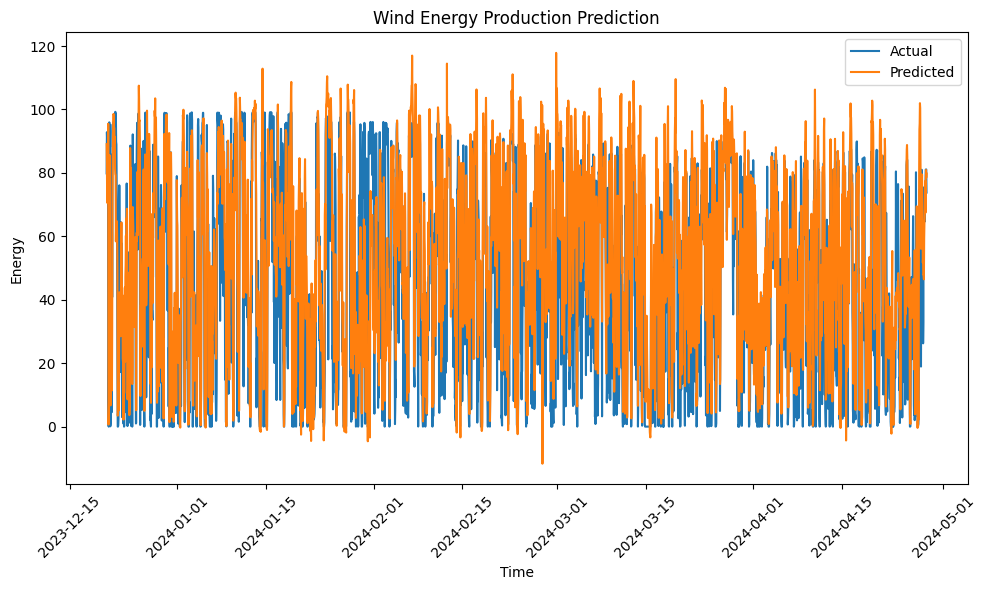

In [27]:
# Plot predictions vs actual values with datetime on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(y_test_original):], y_test_original, label='Actual')
plt.plot(df.index[-len(predictions_original):], predictions_original, label='Predicted')
plt.title('Wind Energy Production Prediction')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Evaluación del modelo Training and Validation Loss

Examining thecurves, you can gain insights into the model's learning dynamics:

**Ideal Scenario:** In an ideal scenario, both training and validation loss should decrease steadily with each epoch, indicating that the model is learning effectively without overfitting.

**Overfitting:** If the training loss decreases while the validation loss starts to increase or remains high, it indicates overfitting. You may observe a significant gap between the training and validation loss curves.

**Underfitting:** If both training and validation loss remain high and do not decrease significantly, it indicates underfitting. In this case, the model may not have enough capacity to capture the underlying patterns in the data.

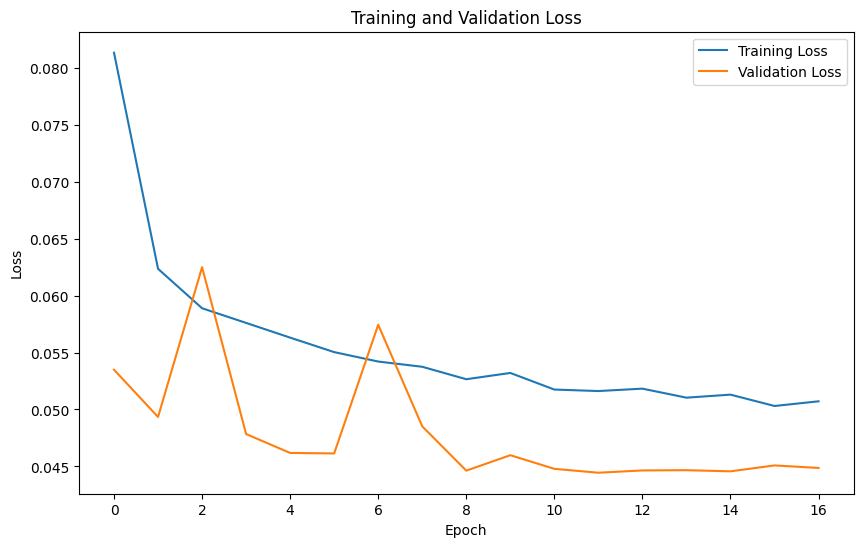

In [28]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Prediccion de valores futuros de EnergiaSMEC utilizando variables exogenas

In [29]:
df_forecast_exog.head()

,AerosDisp,wspd_lstm,wdir,temp,pres,rhum
FechaHora,,,,,,
2024-04-28 09:00:00,29.69,9.57,308.0,9.2,1010.3,59.0
2024-04-28 10:00:00,29.69,9.43,301.0,11.1,1010.1,53.0
2024-04-28 11:00:00,29.69,9.30,294.0,13.0,1009.8,48.0
2024-04-28 12:00:00,29.69,9.10,287.0,14.5,1009.4,43.0
2024-04-28 13:00:00,29.69,8.92,288.0,16.2,1008.6,38.0


In [30]:
# Reshape df_forecast_exog to match the expected input shape for the model
#time_steps = 6
num_features = df_forecast_exog.shape[1]  # Number of features

# Reshape df_forecast_exog
X_forecast_exog = np.zeros((df_forecast_exog.shape[0] - time_steps + 1, time_steps, num_features))

for i in range(time_steps, df_forecast_exog.shape[0] + 1):
    X_forecast_exog[i - time_steps] = df_forecast_exog.values[i - time_steps:i]

# Reshape X_forecast_exog to 2D
X_forecast_exog_2d = X_forecast_exog.reshape(-1, num_features)

# Transform forecast exogenous data using the fitted scaler
X_forecast_exog_scaled = scaler_X.transform(X_forecast_exog_2d)

# Reshape X_forecast_exog_scaled back to 3D
X_forecast_exog_scaled = X_forecast_exog_scaled.reshape(X_forecast_exog.shape)

# Predict future values
future_predictions = model.predict(X_forecast_exog_scaled)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [31]:
X_forecast_exog.shape

(204, 6, 6)

In [32]:
# Inverse transform the scaled predictions to original scale
future_predictions_original = scaler_y.inverse_transform(future_predictions)


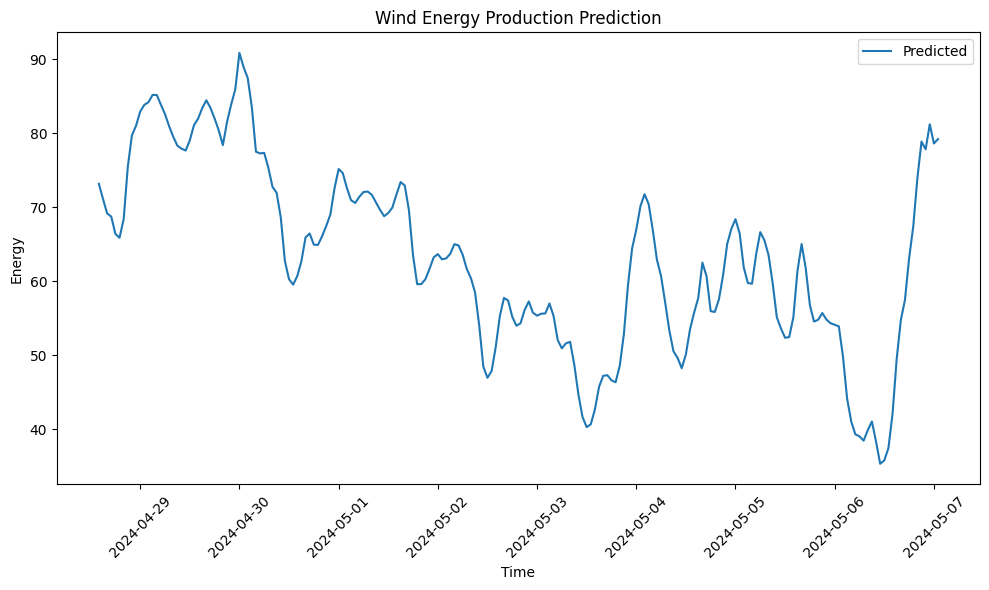

In [33]:
# Plot predictions with time on x-axis
plt.figure(figsize=(10, 6))
plt.plot(df_forecast_exog.index[-len(future_predictions_original):], future_predictions_original, label='Predicted')
#plt.plot(df_forecast_exog.index[-len(future_predictions):], future_predictions, label='Predicted')
plt.title('Wind Energy Production Prediction')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

#### Comparación de valores reales vs predicciones desde el 28/04 9:00 a 03/05 

In [34]:
#path = 'https://github.com/guilledesimone/MMA-Tesis/tree/2f25d7f3f7af31da4c44095d98c137454d83e3d8/Datos/datatest2804.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\datatest2804.csv'

data_types = {                
    'AerosDisp': float
    ,'VelViento': float
    ,'DirViento': float
    ,'TempAmb': float
    ,'HumedadRel': float
    ,'PresionAtm': float
    ,'EnergiaSMEC': float
    ,'wspd_ms_actual': float
    ,'wdir': float
    ,'temp': float
    ,'pres': float
    ,'wspd_lstm': float
    ,'ENERGIA_PRON_CAMMESA': float
}


df_actual = pd.read_csv(path, dtype=data_types, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M:%S', delimiter=';', header=0)

In [35]:
# Convert FechaHora to datetime format
df_actual['FechaHora'] = pd.to_datetime(df_actual['FechaHora'], format='%d/%m/%Y %H:%M')

In [36]:
# Convert the numpy array to a pandas DataFrame
df_predictions_original = pd.DataFrame(future_predictions_original, index=df_forecast_exog.index[-len(future_predictions_original):], columns=['Predicted_Energy'])

# Reset index 
df_predictions_original.reset_index(inplace=True)


In [37]:
# Merge df_actual with df_predictions
df_forcast_actual = pd.merge(df_predictions_original, df_actual[['FechaHora','EnergiaSMEC','wspd_lstm','VelVientoWTGS','wspd_ms_actual','ENERGIA_PRON_CAMMESA']], on='FechaHora', how='left')

df_forcast_actual.head()

,FechaHora,Predicted_Energy,EnergiaSMEC,wspd_lstm,VelVientoWTGS,wspd_ms_actual,ENERGIA_PRON_CAMMESA
0,2024-04-28 14:00:00,73.197670,73.85,8.69,9.43,7.7,89.470
1,2024-04-28 15:00:00,71.150314,73.52,8.39,9.43,7.2,86.335
2,2024-04-28 16:00:00,69.186279,74.89,8.15,9.43,6.7,84.542
3,2024-04-28 17:00:00,68.761917,72.91,8.03,9.55,6.2,83.908
4,2024-04-28 18:00:00,66.422943,75.89,7.62,9.66,4.6,84.155


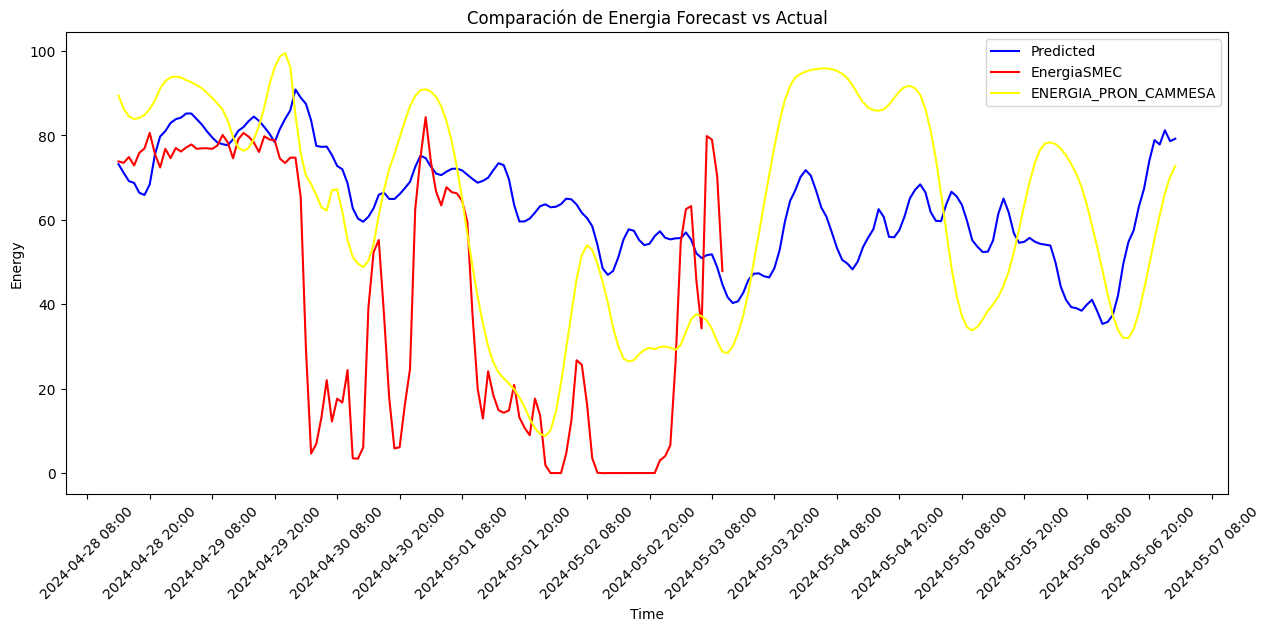

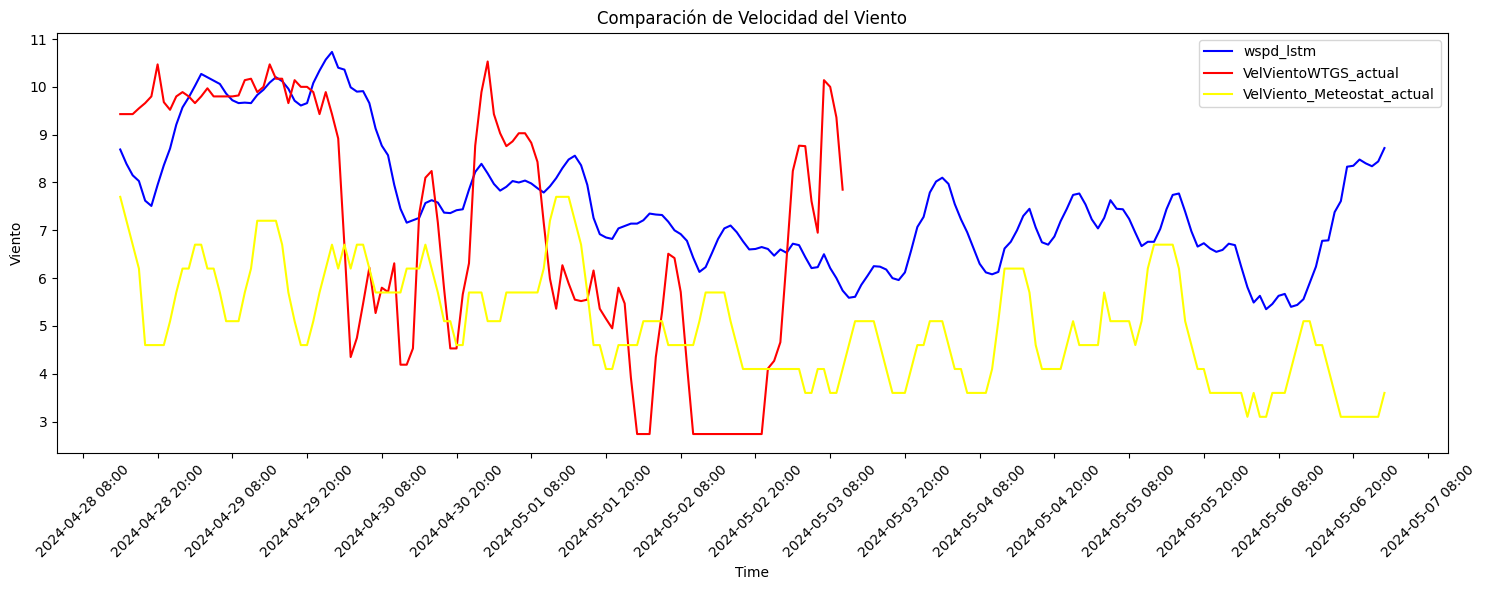

In [38]:
# Increase Figure Size and Rotate X-axis Labels
plt.figure(figsize=(15, 6))  # Increase figure width to 15 inches
plt.plot(df_forcast_actual['FechaHora'], df_forcast_actual['Predicted_Energy'], label='Predicted', color='blue')
plt.plot(df_forcast_actual['FechaHora'], df_forcast_actual['EnergiaSMEC'], label='EnergiaSMEC', color='red')
plt.plot(df_forcast_actual['FechaHora'], df_forcast_actual['ENERGIA_PRON_CAMMESA'], label='ENERGIA_PRON_CAMMESA', color='yellow')
plt.title('Comparación de Energia Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

# Set date format and tick frequency
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=12)) 

plt.figure(figsize=(15, 6))  # Increase figure width to 15 inches
plt.plot(df_forcast_actual['FechaHora'], df_forcast_actual['wspd_lstm'], label='wspd_lstm', color='blue')
plt.plot(df_forcast_actual['FechaHora'], df_forcast_actual['VelVientoWTGS'], label='VelVientoWTGS_actual', color='red')
plt.plot(df_forcast_actual['FechaHora'], df_forcast_actual['wspd_ms_actual'], label='VelViento_Meteostat_actual', color='yellow')
plt.title('Comparación de Velocidad del Viento')
plt.xlabel('Time')
plt.ylabel('Viento')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

# Set date format and tick frequency
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=12))  

plt.tight_layout()
plt.show()